# Example analysis notebook
### Author: Bill Flynn (bill.flynn@jax.org)

Updates:
- 2018-09-28: creation
- 2018-12-10: reboot

This notebook is a template for analysis notebooks using the [`scanpy`](https://github.com/theislab/scanpy) package and an extension to their API I've written tentatively called [`scanpy_recipes`](https://https://github.com/TheJacksonLaboratory/scanpy_recipes).

The aim of the additional functions added to the `scanpy` API by `scanpy_recipes` are intended to simplify scRNA-seq analysis.  Additionally, it's meant to integrate seamlessly with the normal `scanpy` API and as such it only extends functionality.

Specifically, `scanpy` is normally loaded using `import scanpy.api as sc`.  Instead, this package provides this `api` object as

In [1]:
from scanpy_recipes.api import sc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/projects/flynnb/software/anaconda/envs/scc/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/projects/flynnb/software/anaconda/envs/scc/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


This is the same `scanpy.api` object, but has additional functionality.  

Also, note that scanpy's verbosity is turned up so that you can get feedback on exactly what your analysis is doing.  To have less verbosity, enter `sc.settings.verbosity = 0`.

# Key notes

1.  The major workflow will have you creating several `AnnData` objects.  By default, `scanpy` will modify `AnnData` objects inplace.  I find this can get confusing sometimes, especially since finding highly variable genes will remove all genes except the highly variable ones from the default expression matrix (they can still be found in the `AnnData.raw`).

    Instead, this workflow will:
    -   Start by loading `adata_raw`
    -   Generate `adata_qc` through QC processes
    -   Generate `adata_redux` through HVG selection, dimensionality reduction, and clustering.
    
    Each of these objects will be saved, and you can restart any step by loading the object output by the previous step.

2.  

## Loading data

The first major change to the analysis pipeline is to specify data upfront about the samples you will analyze.  To standardize this process, I've written a little parse and template.  

Below, we initialize the parser and print the template.  We then copy the template into a new cell, fill it in, then read it back into the parser which returns a `config` object.  This object is essentially just a dict of dicts which holds the template information.  We can then pass this `config` object to other functions and they will query it when needed for information.  Ultimately, most of this information gets passed onto and stored inside the `AnnData` objects which we will use to store the scRNA-seq data.

Eventually, much of this metadata will be generated automatically through our pipelines but while that is still coming up to speed, we will define it here below.

In [2]:
ac = sc.AnalysisConfig()
ac.print_template()

config_string = """
[names]
customer_name = EXAMPLE_TEXT
analyst_name = EXAMPLE_TEXT
analysis_name = EXAMPLE_TEXT

[sample_names]
EXAMPLE_SAMPLE1 =
EXAMPLE_SAMPLE2 =
EXAMPLE_SAMPLE3 =

[genomes]
EXAMPLE_SAMPLE1 = EXAMPLE_GENOME1
EXAMPLE_SAMPLE2 = EXAMPLE_GENOME2
EXAMPLE_SAMPLE3 = EXAMPLE_GENOME3

[species]
hg19 = hsapiens
GRCh38 = hsapiens
mm10 = mmusculus

[input_dirs]
EXAMPLE_SAMPLE1 = EXAMPLE_DIR1
EXAMPLE_SAMPLE2 = EXAMPLE_DIR2
EXAMPLE_SAMPLE3 = EXAMPLE_DIR3

[output_dirs]
EXAMPLE_SAMPLE1 = EXAMPLE_DIR1
EXAMPLE_SAMPLE2 = EXAMPLE_DIR2
EXAMPLE_SAMPLE3 = EXAMPLE_DIR3

"""
The following sections are required:
['names', 'sample_names', 'genomes', 'species', 'input_dirs', 'output_dirs']


In [3]:
config_string = """
[names]
customer_name = Anonymous person
analyst_name = Bill Flynn
analysis_name = Test-analysis

[sample_names]
PR18016 =

[genomes]
PR18016 = GRCh38

[species]
hg19 = hsapiens
GRCh38 = hsapiens
mm10 = mmusculus

[input_dirs]
PR18016 = /projects/flynnb/singlecell/IBC/PR18016/

[output_dirs]
PR18016 = /fastscratch/flynnb/test-outputs
"""
config = ac.read(config_string)

In [4]:
adata_raw = sc.load_10x_data("PR18016", config)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


This will automatically load lots of relevant **sample-level** metadata into the `AnnData` object:

In [5]:
print(adata_raw)
print("\nSample level metadata:")
for key, value in adata_raw.uns.items():
    print(f"{key:<20}{value}")

AnnData object with n_obs × n_vars = 2145 × 33694 
    obs: 'sequencing_saturation'
    var: 'gene_ids'
    uns: 'sequencing_metrics', 'sampleid', 'genome', 'species', 'analyst', 'customer_name', 'analysis_version', 'date_created', 'input_file', 'input_dir', 'output_dir'

Sample level metadata:
sequencing_metrics  {'Estimated Number of Cells': '2,145', 'Mean Reads per Cell': '173,925', 'Median Genes per Cell': '2,157', 'Number of Reads': '373,069,692', 'Valid Barcodes': '97.6%', 'Sequencing Saturation': '89.4%', 'Q30 Bases in Barcode': '98.2%', 'Q30 Bases in RNA Read': '82.1%', 'Q30 Bases in Sample Index': '97.2%', 'Q30 Bases in UMI': '98.3%', 'Reads Mapped to Genome': '95.6%', 'Reads Mapped Confidently to Genome': '93.2%', 'Reads Mapped Confidently to Intergenic Regions': '5.9%', 'Reads Mapped Confidently to Intronic Regions': '15.9%', 'Reads Mapped Confidently to Exonic Regions': '71.4%', 'Reads Mapped Confidently to Transcriptome': '67.7%', 'Reads Mapped Antisense to Gene': '1.2%', 

## Quality control and filtering

Analysis first starts by generating **per-cell** and **per-gene** metrics, that we can then use to filter the data.

In [6]:
sc.qc.gen_qc(adata_raw)

Several per-cell and per-gene metrics are computed here:
-   per-cell:
    -   `sequencing_satuation`
    -   `percent_mito`
    -   `hemoglobin_counts` (HBB/Hbb-bs counts)
    -   `n_counts` (UMI count across genes)
    -   `n_genes` (gene count)
-   per-gene:
    -   `n_counts` (UMI count across cells)
    -   `n_cells` (cell count)
Additionally, the number of total genes, cells, and empty cells are added to the sample annotations.

In [7]:
print(adata_raw)
print("\nSample level metadata:")
for key, value in adata_raw.uns.items():
    print(f"{key:<20}{value}")

AnnData object with n_obs × n_vars = 2145 × 33694 
    obs: 'sequencing_saturation', 'percent_mito', 'hemoglobin_counts', 'n_counts', 'n_genes'
    var: 'gene_ids', 'n_counts', 'n_cells'
    uns: 'sequencing_metrics', 'sampleid', 'genome', 'species', 'analyst', 'customer_name', 'analysis_version', 'date_created', 'input_file', 'input_dir', 'output_dir', 'raw_cells', 'raw_genes', 'empty_genes', 'obs_titles'

Sample level metadata:
sequencing_metrics  {'Estimated Number of Cells': '2,145', 'Mean Reads per Cell': '173,925', 'Median Genes per Cell': '2,157', 'Number of Reads': '373,069,692', 'Valid Barcodes': '97.6%', 'Sequencing Saturation': '89.4%', 'Q30 Bases in Barcode': '98.2%', 'Q30 Bases in RNA Read': '82.1%', 'Q30 Bases in Sample Index': '97.2%', 'Q30 Bases in UMI': '98.3%', 'Reads Mapped to Genome': '95.6%', 'Reads Mapped Confidently to Genome': '93.2%', 'Reads Mapped Confidently to Intergenic Regions': '5.9%', 'Reads Mapped Confidently to Intronic Regions': '15.9%', 'Reads Mapped

The best way I can think of how to interact with these data to perform QC is to do a "dry run" or trial run of the QC filtering.  To do so, let's first plot how the raw distributions of the per-cell quantities:

In [8]:
def cut_violin(ax, threshold=0., cut_above=[True, False], colors=["0.9", "r"]):
    def cut_verts(polycol, threshold, cut_above, color):
        v = polycol.get_paths()[0].vertices
        if cut_above:
            ind = v[:,1] <= threshold
        else:
            ind = v[:,1] > threshold
        polycol.set_verts([v[ind]])
        polycol.set(facecolor=color)
    cut_verts(ax.collections[0], threshold, cut_above=cut_above[0], color=colors[0])
    cut_verts(ax.collections[2], threshold, cut_above=cut_above[1], color=colors[1])    


def qc_violins(adata):
    keys = sorted(filter(lambda s: not s.startswith("qc"), adata.obs_keys()))
    N = len(keys)

    thresholds = adata.uns.get("qc_cell_filter", None)
    use_thresholds = dict(zip(keys, [False]*N))
    if thresholds:
        use_thresholds = dict((key, thresholds.get("threshold_" + key, None)) for key in keys)
    
    fig, axs = plt.subplots(1, N, figsize=(4*N, N), dpi=200)
    for ax, key in zip(axs.flat, keys):
        threshold = use_thresholds[key]
        print(key, threshold)
        if threshold:
            ax = sc.pl.violin(adata, key, color="blue", show=False, ax=ax, cut=0)
            ax = sc.pl.violin(adata, key, color="blue", show=False, ax=ax, cut=0, jitter=False)
            cut_violin(ax, threshold=threshold, 
                       cut_above=[True, False] if key == "percent_mito" else [False, True])
            ax.axhline(threshold, xmin=0.25, xmax=0.75, color="r")
            #return ax
        else:
            sc.pl.violin(adata, key, show=False, ax=ax, cut=0, color="0.9")

        ax.set_title(adata.uns["obs_titles"][key])
        ax.set_xticks([])
        ax.set_ylabel("")
        sns.despine(fig, ax)
    fig.tight_layout()

hemoglobin_counts False
n_counts False
n_genes False
percent_mito False
sequencing_saturation False


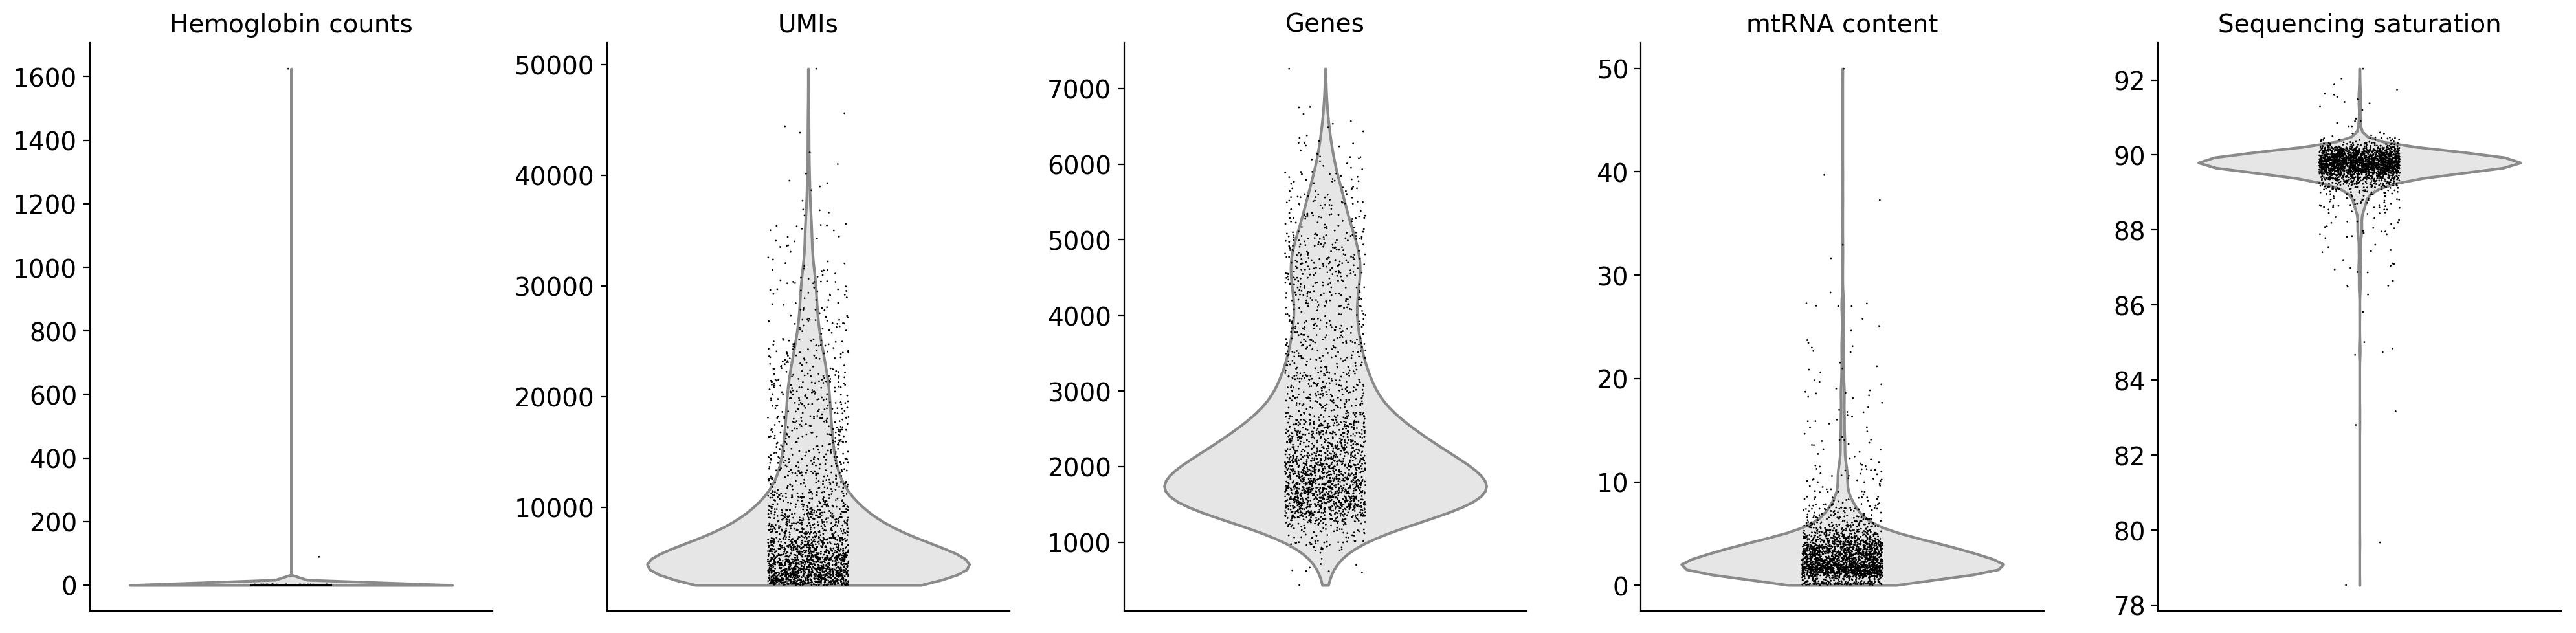

In [9]:
qc_violins(adata_raw)

Given these distributions, we can set thresholds for each variable in addition to standard cell and gene filters:
-   exclude genes with fewer than `min_counts_per_gene` in fewer than `min_cells_per_gene` (e.g. fewer than 3 counts in fewer than 3 cells)
-   exclude cells with fewer than `min_counts_per_cell` (UMIs) or fewer than `min_genes_per_cell`.
-   exclude cells with sequencing saturation below `sequencing_saturation`
-   exclude cells with mtRNA content greater than `percent_mito`%
-   exclude cells with more than `rbc_threshold` hemoglobin gene counts

If you don't want to threshold/filter by a criteria (like sequencing saturation or RBCs), just set those to `None`.

If we know exactly what we want, we can go ahead and set these filter values which will return a copy of the filtered AnnData object.  However, if we're unsure, we can pass the `trial = True` argument, which will return a copy of the *unfiltered* object with cells that would be removed annotated:
-   `adata.obs["qc_fail"]`: overall pass or fail annotation for each cell
-   `adata.obs["qc_fail_counts"]`: True if cell fails count thresholds
-   `adata.obs["qc_fail_seqsat"]`: True if cell fails sequencing saturation thresholds
-   `adata.obs["qc_fail_mito"]`: True if cell fails mtRNA content thresholds
-   `adata.obs["qc_fail_rbc"]`: True if cell fails hemoglobin thresholds

In [10]:
trial = sc.qc.run_qc(adata_raw,
                     min_cells_per_gene=3,
                     min_counts_per_gene=3,
                     min_counts_per_cell=500,
                     min_genes_per_cell=200,
                     sequencing_saturation=None,
                     percent_mito=10.0, 
                     rbc_threshold=10,
                     trial=True)

filtered out 13967 genes that are detected in less than 3 cells
Original dims: (2145, 33694)
Filtered dims: (2048, 19727)


In [11]:
trial.obs.qc_fail.value_counts()

pass    2048
fail      97
Name: qc_fail, dtype: int64

Passing the `trial` object through the same violin plotting function returns similar plots with the cells that failed QC highlighted.  Metrics that were used for filtering will show the threshold level as a horizontal line.

hemoglobin_counts 10
n_counts 500
n_genes 200
percent_mito 10.0
sequencing_saturation None


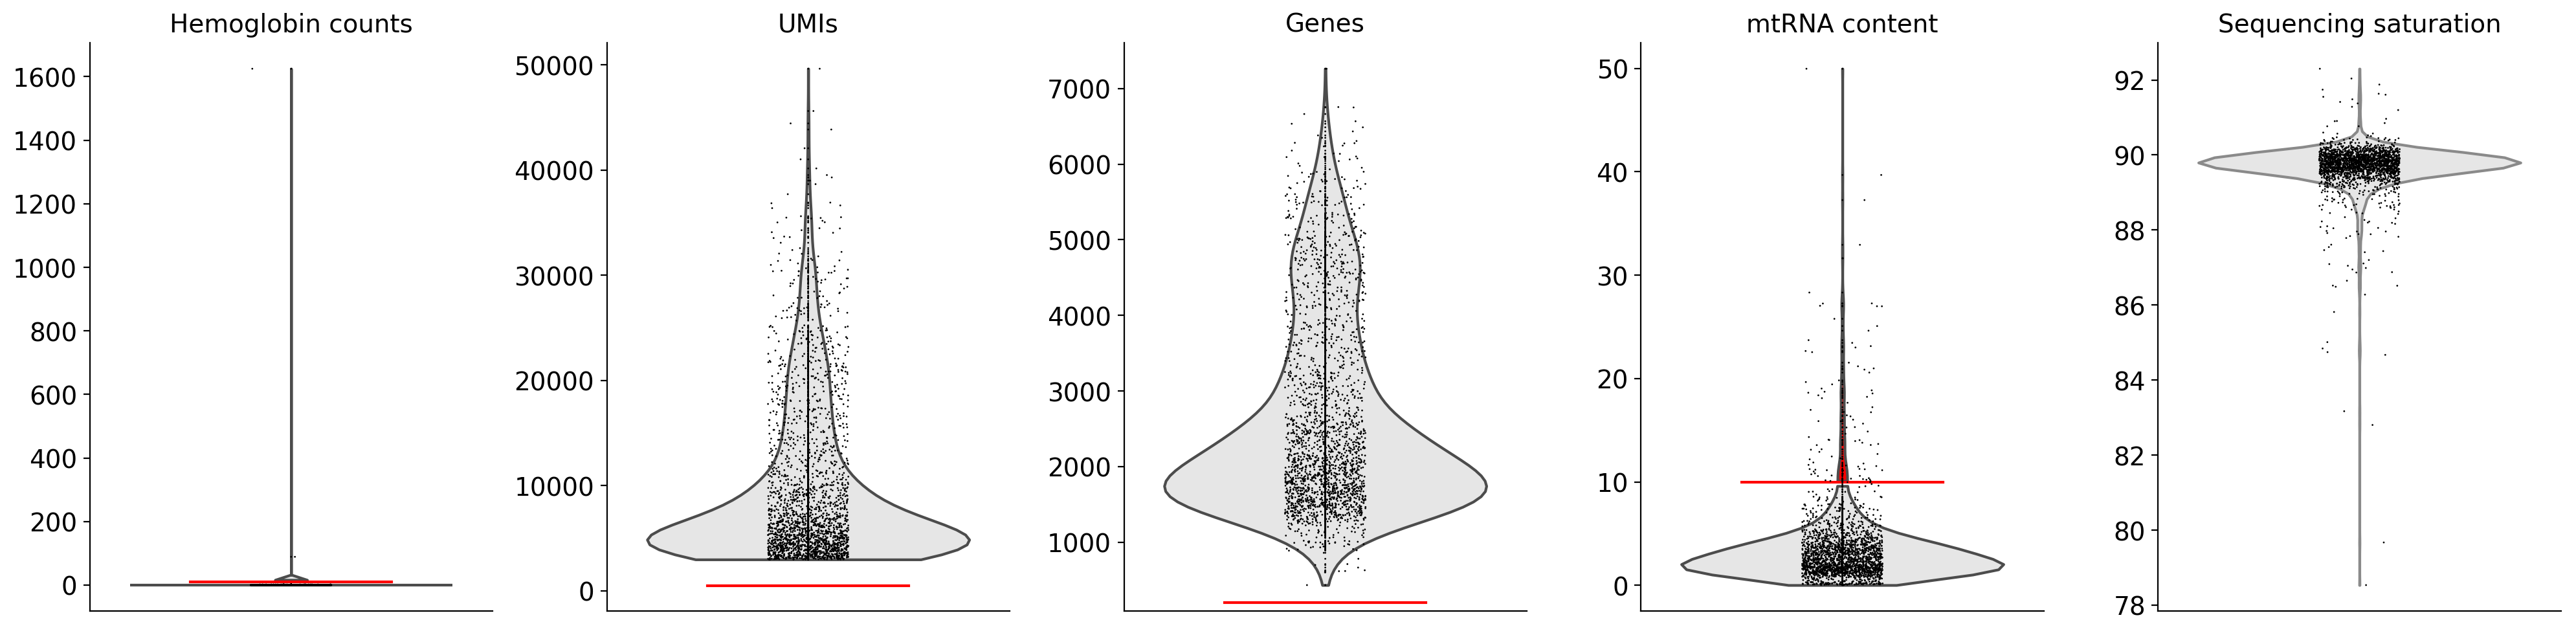

In [12]:
ax = qc_violins(trial)

Once we're comfortable with the appropriate filtering parameters, let's do the following so that we can generate QC plots.

In [13]:
qc_params = dict(
    min_cells_per_gene=3,
    min_counts_per_gene=3,
    min_counts_per_cell=500,
    min_genes_per_cell=200,
    sequencing_saturation=None,
    percent_mito=10.0, 
    rbc_threshold=10
)

In [14]:
trial = sc.qc.run_qc(adata_raw, trial=True, **qc_params)
adata_qc = sc.qc.run_qc(adata_raw, trial=False, **qc_params)

filtered out 13967 genes that are detected in less than 3 cells
Original dims: (2145, 33694)
Filtered dims: (2048, 19727)
filtered out 13967 genes that are detected in less than 3 cells
Original dims: (2145, 33694)
Filtered dims: (2048, 19727)


In [15]:
trial.obs_keys()

['sequencing_saturation',
 'percent_mito',
 'hemoglobin_counts',
 'n_counts',
 'n_genes',
 'qc_fail_counts',
 'qc_fail_seqsat',
 'qc_fail_mito',
 'qc_fail_rbc',
 'qc_fail']

In [16]:
def genes_umis_scatter(adata_trial):
    def _scat(fig, ax, adata_trial, key, cmap="Reds", cbar=True, sort_top=True):
        pdata = adata_trial.obs[["n_counts", "n_genes", key]]
        print(pdata[key].dtype)
        if isinstance(pdata[key].dtype, pd.api.types.CategoricalDtype):
            print('inside')
            pdata[key] = pdata[key].cat.codes
        pdata = pdata.sort_values(key, ascending=sort_top)

        p = ax.scatter(pdata["n_counts"],
                       pdata["n_genes"],
                       c=pdata[key].values, linewidths=0.05, edgecolors="k",
                       s=12, alpha=0.6, cmap=cmap)
        if cbar:
            fig.colorbar(p, ax=ax)
        ax.set_title(adata_trial.uns["obs_titles"].get(key, "Overall QC"))
        ax.set_xlabel("UMIs")
        ax.set_ylabel("Genes")
        sns.despine(fig, ax)

    keys = sorted(filter(lambda s: not s.startswith("qc") and not s.startswith("n_"), adata_trial.obs_keys()))
    L = len(keys) + 1
    
    fig, axs = plt.subplots(1, L, figsize=(L*4, 3))
    for ax, key in zip(axs.flatten(), keys):
        _scat(fig, ax, adata_trial, key)
    redblue = sns.blend_palette([sns.xkcd_rgb["light red"], "0.9"], 2, as_cmap=True)
    _scat(fig, axs.flatten()[-1], adata_trial, "qc_fail", cmap=redblue, cbar=False, sort_top=False)
    
    fig.tight_layout()

float32
float32
float64
category
inside


/projects/flynnb/software/anaconda/envs/scc/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


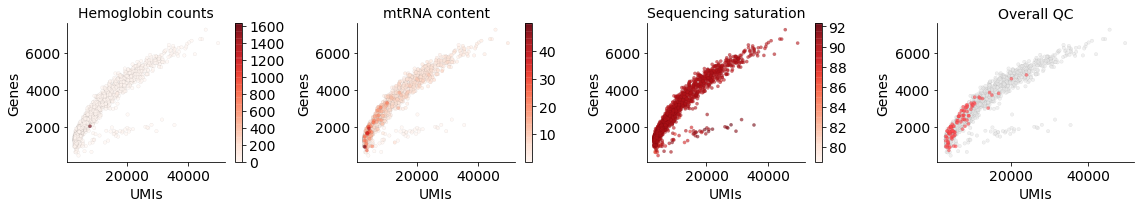

In [17]:
genes_umis_scatter(trial)

In [18]:
qc_message = (
    "After QC, the cell-gene matrix contains {cells} cells and {genes} genes.\n"
    "1.  {low_count_genes_removed} were removed due to too few counts.\n"
    "2.  {cells_removed} were removed due to several factors.\n"
    "2a.  {low_count_cells_removed} were removed due to low UMI and gene counts.\n"
    "2b.  {red_blood_cells_removed} were removed due to high counts of hemoglobin markers.\n"
    "2c.  {high_mtrna_cells_removed} were removed due to high mtRNA content.\n"
    "2d.  {low_sequencing_saturation_cells_removed} were removed due to low per-cell sequencing saturation.\n")
print(qc_message.format(**trial.uns["qc_metrics"]))

After QC, the cell-gene matrix contains 2048 cells and 19727 genes.
1.  13967 were removed due to too few counts.
2.  97 were removed due to several factors.
2a.  0 were removed due to low UMI and gene counts.
2b.  2 were removed due to high counts of hemoglobin markers.
2c.  95 were removed due to high mtRNA content.
2d.  0 were removed due to low per-cell sequencing saturation.



## Highly variable gene selection and dimensionality reduction

Now that the data is filtered, we want to find highly variable genes and reduce the dimensionality of the data.  I've split this up into two steps:
1. `preprocess`
2. `dimensionality_reduction`

The first finds highly variable genes and normalizes, log transforms, and scales the data.  The default scanpy way to do this will just subset the `adata_qc` to only have the highly variable genes.  The way I've written does things differently, yielding two objects:
*   `adata_full`:
    -   `adata_full` contains log-transformed, normalized UMI counts for all genes.
    -   `adata_full.raw` contains normalized UMI counts for all genes (just `sc.pp.normalize_per_cell(adata_qc)`).
*   `adata_redux`:
    -   `adata_redux` contains scaled, log-transformed, normalized UMI counts for highly variable genes.
    -   `adata_redux.raw` contains normalized UMI counts for all genes (same as `adata_full.raw`).

In most cases, you won't use `adata_full`, but it's nice to keep it just in case you need the full normalized counts (as the `.raw` objects are hard to work with).  `adata_redux` is what will be used for dimensionality reduction and clustering.

The second computes PCA (50 components), a nearest-neighbor graph, and both 2 and 3 dimensional UMAP representations of the data from the `adata_redux` object.  I use the 2D representation to generate the plots for the initial report and the 3D representation for CellView.

In [19]:
adata_full, adata_redux = sc.pp.preprocess(adata_qc, n_top_genes=1000, scale=True)

If you pass `n_top_genes`, all cutoffs are ignored.


In [20]:
print("adata_full:", adata_full.shape, "adata_full.raw:", adata_full.raw.X.shape)
print("adata_redux:", adata_redux.shape, "adata_redux.raw:", adata_redux.raw.X.shape)

adata_full: (2048, 19727) adata_full.raw: (2048, 19727)
adata_redux: (2048, 999) adata_redux.raw: (2048, 19727)


In [21]:
sc.pp.dimensionality_reduction(adata_redux, is_aggregation=False, 
                               n_neighbors=10, min_dist=0.5)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:09.14) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:07.30) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing UMAP
    finished (0:00:05.42) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [22]:
for key in adata_redux.obsm_keys():
    print(key, adata_redux.obsm[key].shape)

X_pca (2048, 50)
X_umap (2048, 2)
X_umap_3d (2048, 3)


## Clustering

In [23]:
sc.tl.cluster(adata_redux, )

running Leiden clustering
    finished (0:00:00.29) --> found 22 clusters and added
    'cluster', the cluster labels (adata.obs, categorical)


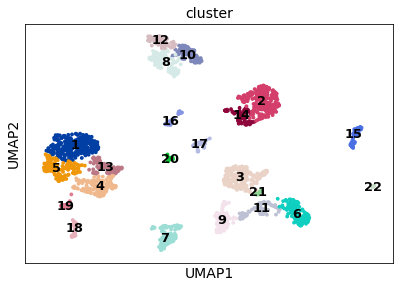

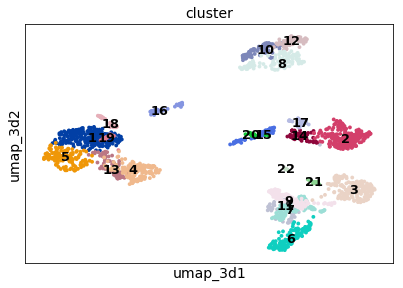

In [24]:
sc.pl.scatter(adata_redux, basis="umap", color="cluster", legend_loc="on data")
sc.pl.scatter(adata_redux, basis="umap_3d", color="cluster", legend_loc="on data")

Sometimes, you may want to break apart certain clusters:

In [25]:
sc.tl.subcluster(adata_redux, cluster="16", cluster_key="cluster")

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 2 clusters and added
    'cluster_R1', the cluster labels (adata.obs, categorical)
Updated clusters under `adata_redux.obs['cluster_R1']`.


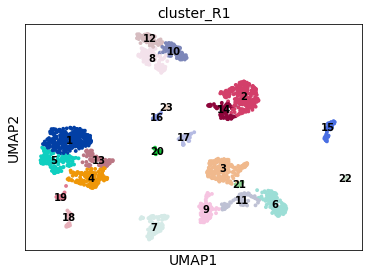

In [26]:
sc.pl.umap(adata_redux, color="cluster_R1", legend_loc="on data")

This can be done multiple times; just notice that the clustering key gets incremented each time.

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 3 clusters and added
    'cluster_R2', the cluster labels (adata.obs, categorical)
Updated clusters under `adata_redux.obs['cluster_R2']`.
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 3 clusters and added
    'cluster_R3', the cluster labels (adata.obs, categorical)
Updated clusters under `adata_redux.obs['cluster_R3']`.


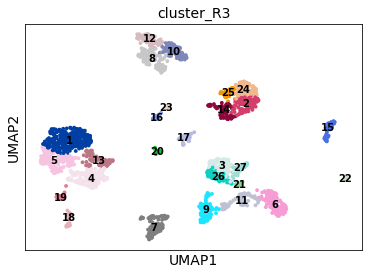

In [27]:
sc.tl.subcluster(adata_redux, "2", cluster_key="cluster_R1")
sc.tl.subcluster(adata_redux, "3", cluster_key="cluster_R2")
sc.pl.umap(adata_redux, color="cluster_R3", legend_loc="on data")

## Marker gene detection

In [28]:
def scalpel_markers(adata, cluster_key="cluster"):
    tmpd = pd.DataFrame(np.asarray(adata.raw.X.todense()),
                        index=adata.obs_names,
                        columns=adata.raw.var_names)
    tmpd = sc.AnnData(tmpd, var=adata.raw.var, obs=adata.obs)

    sc.pp.normalize_per_cell(tmpd)
    sc.pp.log1p(tmpd)
    counts = pd.DataFrame(tmpd.X, columns=tmpd.var_names, index=tmpd.obs_names).T
    #counts = np.log1p(counts)
    
    features = pd.DataFrame({'Associated.Gene.Name': counts.index, 'Chromosome.Name': 1}, index=counts.index)

    umap = adata.obsm["X_umap"]
    if umap.shape[1] == 2:
        umap = np.column_stack((umap, np.zeros(umap.shape[0])))
    tsne = pd.DataFrame(umap, columns=['V1', 'V2', 'V3'], index=adata.obs_names)
    tsne['dbCluster'] = adata.obs[cluster_key].cat.codes + 1
    
    markers = spl.identify_markers(counts, tsne, features, fold_change_threshold=0.8)
    return markers

## Report generation

## Saving outputs

Ultimately, the Rds file just holds 3 data frames, `log2cpm`, `featuredata`, and `tnse.data`.  Instead of taking a load of bloaty R code to do this, from now on we will just export these data to csv then submit a job to helix that will generate the Rds from these files.  However, we include job submission of this file here.

In [29]:
from datetime import datetime
datestamp = lambda : datetime.now().strftime("%Y%m%d")
import os
def save_adata(obj, suffix):
    outname = f"{obj.uns['sampleid']}-{suffix}_{datestamp()}.h5ad"
    outfile = os.path.join(obj.uns["output_dir"], outname)
    print(f"Saving {outname} to {obj.uns['output_dir']}.")
    sc.write(outfile, obj)
    
def save_all_adata():
    adata_objects = list(filter(lambda x: x.startswith("adata"), globals().keys()))
    for object_name in adata_objects:
        suffix = object_name.split("_")[1]
        obj = eval(object_name)
        save_adata(obj, suffix)

In [33]:
def quantile_limit(obj, q=0.99):
    obj[obj > obj.quantile(0.99)] = obj.quantile(0.99)
    return obj

def save_adata_to_rds(adata, cluster_key="cluster", aggr=False, n_dims=3):
    tmpd = pd.DataFrame(np.asarray(adata.raw.X.todense()),
                        index=adata.obs_names,
                        columns=adata.raw.var_names)
    tmpd = sc.AnnData(tmpd, var=adata.raw.var, obs=adata.obs)

    # if `.raw` counts aren't normalized, normalize them.
    # if they are, then normalization will return the same values (they're already normalized)
    sc.pp.normalize_per_cell(tmpd)
    sc.pp.log1p(tmpd)
    counts = pd.DataFrame(tmpd.X, columns=tmpd.var_names, index=tmpd.obs_names).T
    
    features = pd.DataFrame({'Associated.Gene.Name': counts.index, 'Chromosome.Name': 1}, index=counts.index)

    counts.ix['ENSGGENES'] = quantile_limit(adata.obs['n_genes'])
    counts.ix['ENSGUMI'] = quantile_limit(adata.obs['n_counts'])
    counts.ix['ENSGMITO'] = quantile_limit(adata.obs['percent_mito'])
    counts.ix['ENSGSEQSAT'] = quantile_limit(adata.obs['sequencing_saturation'])
    if aggr:
        counts.ix["ENSGSAMP"] = adata.obs.batch.cat.codes
        features.ix["ENSGSAMP"] = ["Sample", 1]
    
    features.ix['ENSGGENES'] = ['Genes', 1]
    features.ix['ENSGUMI'] = ['Umi', 1]
    features.ix['ENSGMITO'] = ['PercentMito', 1]
    features.ix['ENSGSEQSAT'] = ['Saturation', 1]

    if n_dims == 3:
        umap = adata.obsm["X_umap_3d"]
    else:
        umap = adata.obsm["X_umap"]
        umap = np.column_stack((umap, np.zeros(umap.shape[0])))
    tsne = pd.DataFrame(umap, columns=['V1', 'V2', 'V3'], index=adata.obs_names)
    tsne['dbCluster'] = adata.obs[cluster_key].cat.codes + 1
    
    outdir = adata.uns["output_dir"]
    for data, out_type in zip((counts, features, tsne),
                              ("counts", "features", "tsne")):
        outname = "{adata.uns['sampleid']}_{out_type}.csv"
        outfile = os.path.join(outdir, outname)
        data.to_csv(outfile)
        print(f"Saved {out_type} to {outfile}.")
    
#    spl.read_write._make_rds(counts, features, tsne, outfile)

In [49]:
save_all_adata()

Saving PR18016-raw_20181211.h5ad to /fastscratch/flynnb/test-outputs.
Saving PR18016-qc_20181211.h5ad to /fastscratch/flynnb/test-outputs.
Saving PR18016-full_20181211.h5ad to /fastscratch/flynnb/test-outputs.
Saving PR18016-redux_20181211.h5ad to /fastscratch/flynnb/test-outputs.
